In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
%matplotlib inline


In [ ]:
%matplotlib inline

In [6]:
user = "sy91dhb"
password = "g5t49ao"
host = "178.156.142.230"
port = "5432"
db = "hd64m1ki"

engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}")

In [ ]:
# Create a view for recent stories with non-null "by" column

create_stories_view_query = """
CREATE OR REPLACE VIEW hacker_news.recent_stories AS
SELECT *
FROM hacker_news.items
WHERE EXTRACT(year from time) >= 2011 
  AND type = 'story' 
  AND "by" IS NOT NULL;
"""

# Execute the query to create the view
with engine.connect() as conn:
    conn.execute(create_stories_view_query)
    conn.commit()
    
print("View 'recent_stories' created successfully!")

In [8]:
frequent_posters = pd.read_sql('''SELECT 
	"by", 
  COUNT(*) AS post_count
FROM hacker_news.items
WHERE EXTRACT(year from time) >= 2011 AND type = 'story' AND "by" IS NOT NULL
GROUP BY "by"
ORDER BY post_count DESC
LIMIT 100;''', engine)
frequent_posters.head()


,by,post_count
0,rbanffy,30770
1,Tomte,23651
2,tosh,20917
3,pseudolus,16944
4,bookofjoe,16097


In [ ]:
#posters with popular posts
popular_posters = pd.read_sql('''SELECT 
	"by",                             
  AVG(score) AS avg_score
FROM hacker_news.items
WHERE EXTRACT(year from time) >= 2011 AND type = 'story' AND "by" IS NOT NULL
GROUP BY "by"
ORDER BY avg_score DESC
LIMIT 100;''', engine)
popular_posters.head()

In [15]:
popular_posters.describe()


,avg_score
count,100.000000
mean,1460.806667
std,580.247784
min,967.000000
25%,1092.250000
50%,1236.500000
75%,1631.000000
max,4240.000000


## Posts by time

In [26]:
by_hour = pd.read_sql('''SELECT 
  EXTRACT(hour from time) AS hour,
  score,
  COUNT(*) as count
FROM hacker_news.items
WHERE EXTRACT(year from time) >= 2011 
                      AND type = 'story' AND "by" IS NOT NULL
                      AND score > 0
GROUP BY hour, score''', engine)
by_hour.head()


,hour,score,count
0,0.0,1,58158
1,0.0,2,31079
2,0.0,3,15817
3,0.0,4,7934
4,0.0,5,4759


C:\Users\nikol\AppData\Local\Temp\ipykernel_39164\1108095321.py:29: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 500)  # Focus on reasonable score range


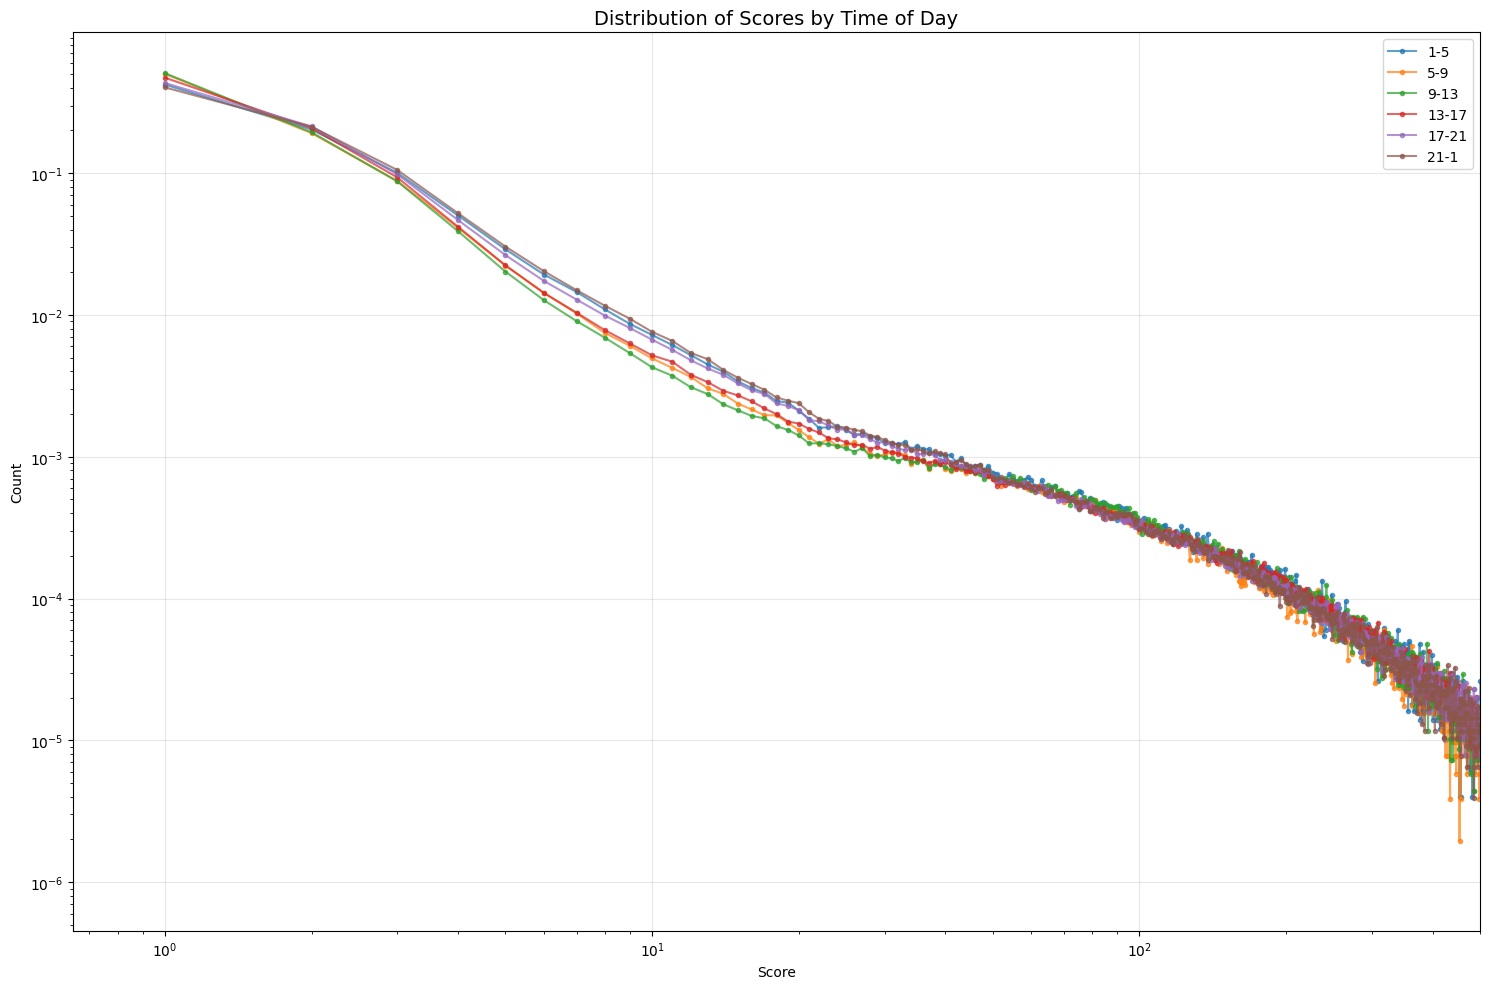

In [27]:

# Plot histogram of scores for 6 time ranges
plt.figure(figsize=(15, 10))

# Define time ranges
time_ranges = [(1,5), (5,9), (9,13), (13,17), (17,21), (21,1)]
time_labels = ['1-5', '5-9', '9-13', '13-17', '17-21', '21-1']

# Plot histogram for each time range
for i, (start, end) in enumerate(time_ranges):
    if start < end:
        #
        range_data = by_hour[by_hour['hour'].between(start, end-1)]
    else:  # Handle wraparound case (21-1)
        range_data = by_hour[(by_hour['hour'] >= start) | (by_hour['hour'] < end)]
    
    # Group by score and sum the counts across hours in this time range
    aggregated = range_data.groupby('score')['count'].sum().reset_index()
    
    # Plot the aggregated data for the given time range
    plt.plot(aggregated['score'], aggregated['count']/sum(aggregated['count']), alpha=0.7, label=f'{time_labels[i]}', marker='.')

plt.title('Distribution of Scores by Time of Day', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Score')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 500)  # Focus on reasonable score range
plt.tight_layout()
plt.show()


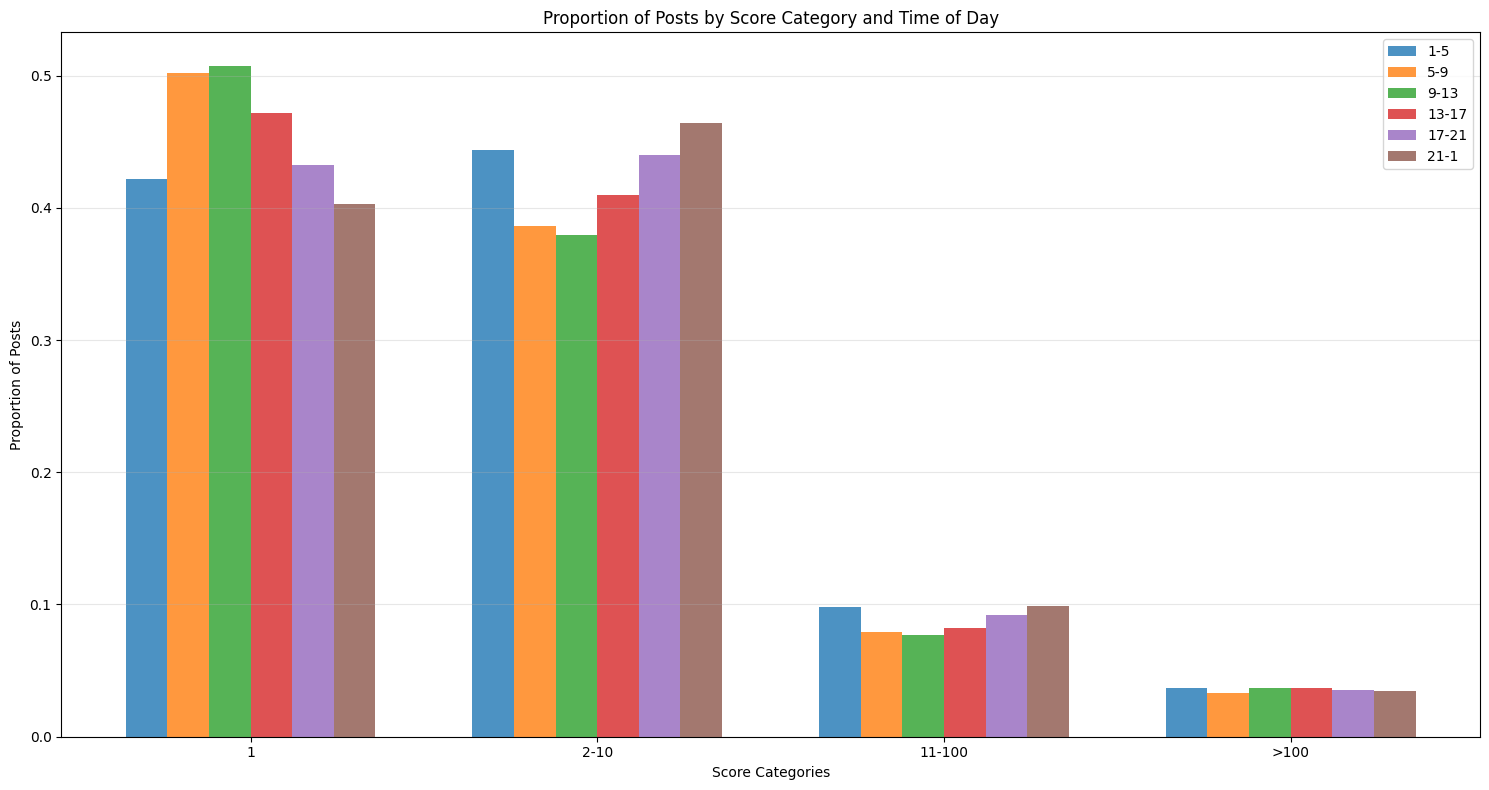

In [31]:
# Second figure: Aggregated score categories by time range
plt.figure(figsize=(15, 8))

# Define score categories
def categorize_score(score):
    if score == 1:
        return '1'
    elif 2 <= score <= 10:
        return '2-10'
    elif 11 <= score <= 100:
        return '11-100'
    else:
        return '>100'

# Define time ranges (same as before)
time_ranges = [(1,5), (5,9), (9,13), (13,17), (17,21), (21,1)]
time_labels = ['1-5', '5-9', '9-13', '13-17', '17-21', '21-1']

# Prepare data for plotting
categories = ['1', '2-10', '11-100', '>100']
data_for_plot = {category: [] for category in categories}

# Process each time range
for i, (start, end) in enumerate(time_ranges):
    if start < end:
        range_data = by_hour[by_hour['hour'].between(start, end-1)]
    else:  # Handle wraparound case (21-1)
        range_data = by_hour[(by_hour['hour'] >= start) | (by_hour['hour'] < end)]
    
    # Group by score and sum the counts across hours in this time range
    aggregated = range_data.groupby('score')['count'].sum().reset_index()
    
    # Categorize scores and sum counts
    aggregated['category'] = aggregated['score'].apply(categorize_score)
    category_counts = aggregated.groupby('category')['count'].sum()
    
    # Calculate total posts for this time range
    total_posts = category_counts.sum()
    
    # Store proportions for each category (0 if category doesn't exist)
    for category in categories:
        count = category_counts.get(category, 0)
        proportion = count / total_posts if total_posts > 0 else 0
        data_for_plot[category].append(proportion)

# Create bar plot - grouped by score category
x = np.arange(len(categories))
width = 0.12

for i, time_label in enumerate(time_labels):
    values = [data_for_plot[category][i] for category in categories]
    plt.bar(x + i*width, values, width, 
            label=f'{time_label}', alpha=0.8)

plt.xlabel('Score Categories')
plt.ylabel('Proportion of Posts')
plt.title('Proportion of Posts by Score Category and Time of Day')
plt.xticks(x + width*2.5, categories)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


In [33]:
#same, but for day of the week
by_weekday = pd.read_sql('''
SELECT 
  to_char(time, 'Day') AS day,
  score, 
  COUNT(*) as count
FROM hacker_news.items
WHERE EXTRACT(year from time) >= 2011 
                      AND type = 'story' AND "by" IS NOT NULL
                      AND score > 0
GROUP BY day, EXTRACT(ISODOW from time), score
ORDER BY EXTRACT(ISODOW from time);''', engine)
by_weekday.head()

,day,score,count
0,Monday,1,344024
1,Monday,2,151026
2,Monday,3,69614
3,Monday,4,32211
4,Monday,5,17482


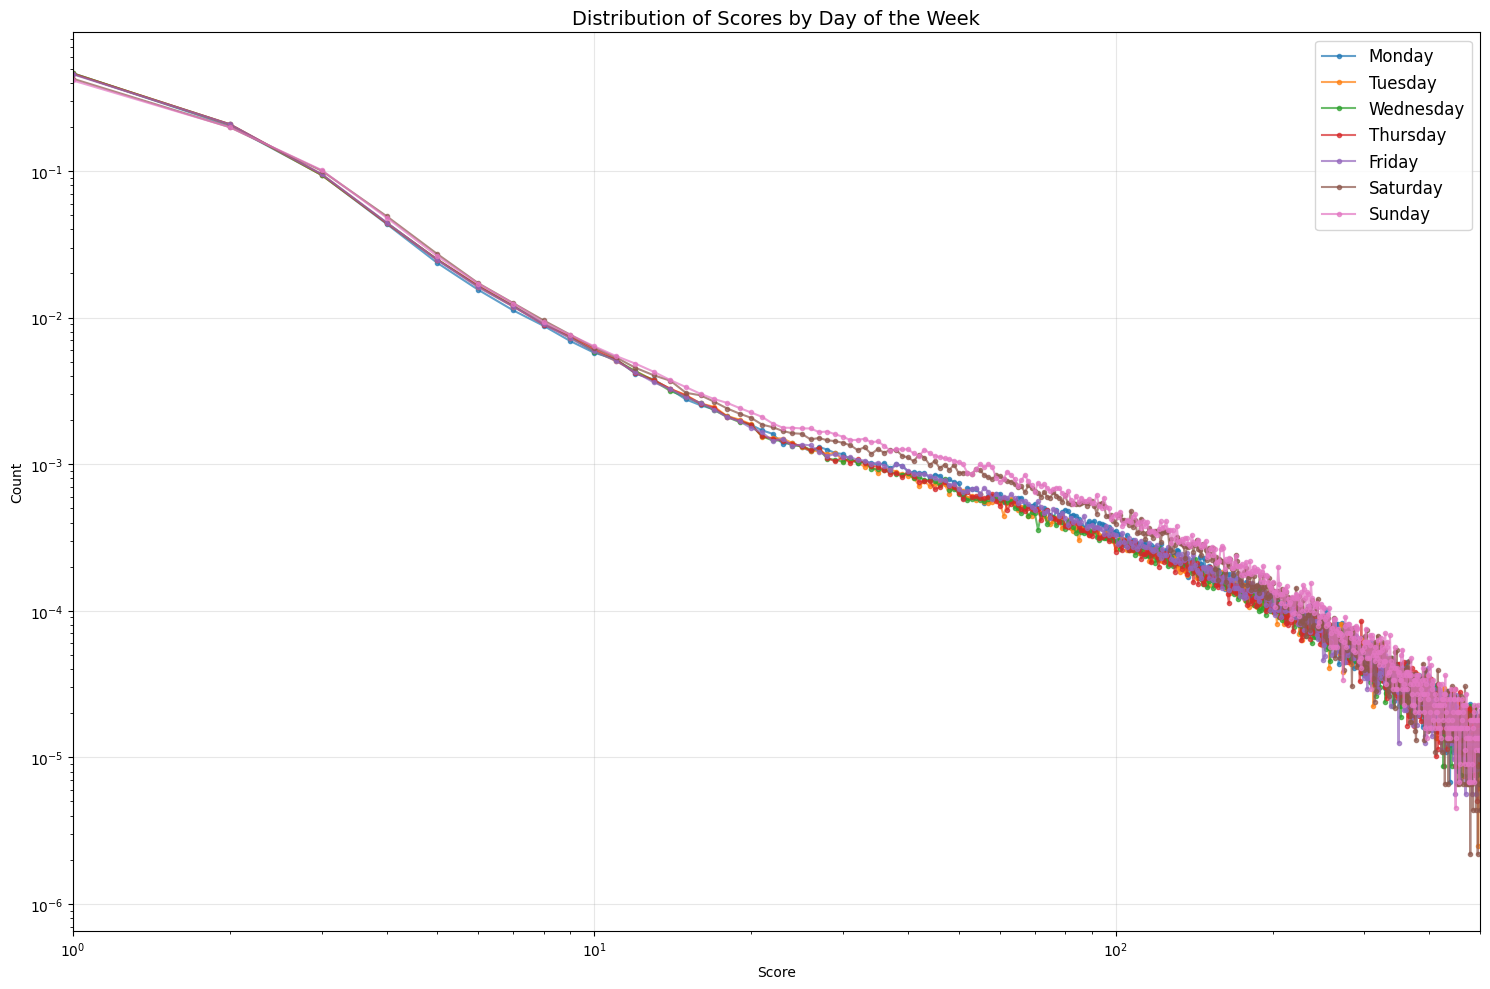

In [48]:
def plot_loglog(score_data, category, category_items, category_labels, title, xlabel='Score', ylabel='Count'):
    plt.figure(figsize=(15, 10))
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=14)
    # Plot histogram for each day of the week
    for i, item in enumerate(category_items):
        item_data = score_data[score_data[category] == item]
        # Group by score and sum the counts across hours in this time range
        aggregated = item_data.groupby('score')['count'].sum().reset_index()
        
        # Plot the aggregated data for the given time range
        plt.plot(aggregated['score'], aggregated['count']/sum(aggregated['count']), alpha=0.7, label=category_labels[i], marker='.')
    plt.xlim(1, 500)  # Focus on reasonable score range
    plt.legend(fontsize=12)  # Move legend AFTER plotting
    plt.tight_layout()
    plt.show()

# Define proper day order 
day_order = ['Monday   ', 'Tuesday  ', 'Wednesday', 'Thursday ', 'Friday   ', 'Saturday ', 'Sunday   ']  # Note: PostgreSQL to_char pads with spaces
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plot_loglog(by_weekday, 'day', day_order, day_labels, 'Distribution of Scores by Day of the Week')




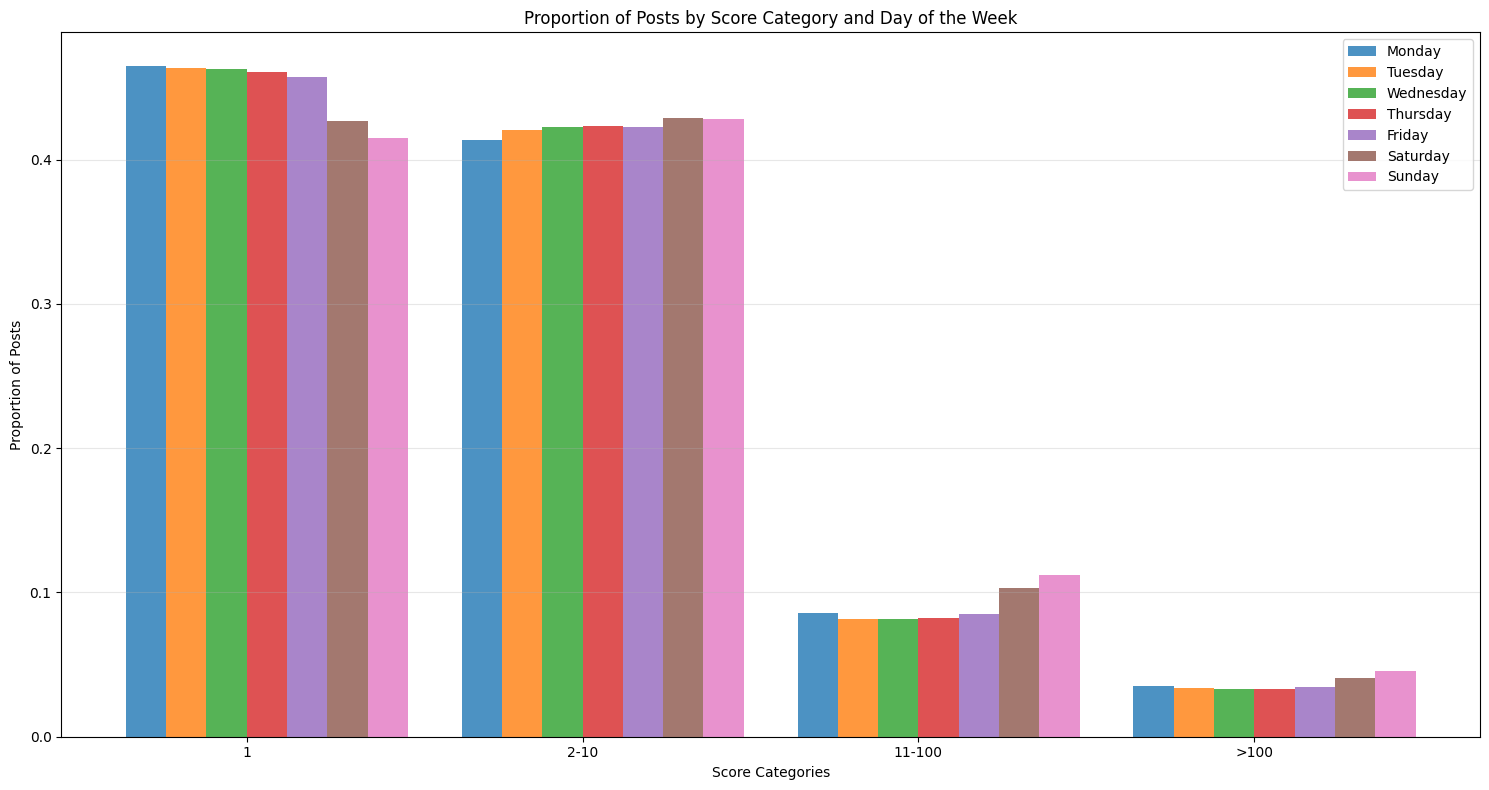

In [54]:
def show_score_categories(data, cat, cat_items, cat_labels, title):
# Aggregated score categories by day of the week
    plt.figure(figsize=(15, 8))


    #Gather data for each score category
    data_for_plot = {category: [] for category in categories}


    # Process each day of the week
    for i, item in enumerate(cat_items):
        item_data = data[data[cat] == item]
    
        # Group by score and sum the counts across hours in this time range
        aggregated = item_data.groupby('score')['count'].sum().reset_index()
        
        # Categorize scores and sum counts
        aggregated['category'] = aggregated['score'].apply(categorize_score)
        category_counts = aggregated.groupby('category')['count'].sum()
        
        # Calculate total posts for this time range
        total_posts = category_counts.sum()
        
        # Store proportions for each category (0 if category doesn't exist)
        for category in categories:
            count = category_counts.get(category, 0)
            proportion = count / total_posts if total_posts > 0 else 0
            data_for_plot[category].append(proportion)

    # Create bar plot - grouped by score category
    x = np.arange(len(categories))
    width = 0.12

    for i, item in enumerate(cat_items):
        values = [data_for_plot[category][i] for category in categories]
        plt.bar(x + i*width, values, width, 
                label=cat_labels[i], alpha=0.8)

    plt.xlabel('Score Categories')
    plt.ylabel('Proportion of Posts')
    plt.title(title)
    plt.xticks(x + width*2.5, categories)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

show_score_categories(by_weekday, 'day', day_order, day_labels, 'Proportion of Posts by Score Category and Day of the Week')

In [ ]:
#Do this again, but for each month
by_month = pd.read_sql('''
SELECT 
  to_char(time, 'Month') AS month,
  score, 
  COUNT(*) as count
FROM hacker_news.items
WHERE EXTRACT(year from time) >= 2011 
                      AND type = 'story' AND "by" IS NOT NULL
                      AND score > 0
GROUP BY month, EXTRACT(MONTH from time), score
ORDER BY EXTRACT(MONTH from time);''', engine)
by_month.head()

,month,score,count
0,January,1,182143
1,January,2,85336
2,January,3,41010
3,January,4,18816
4,January,5,10504


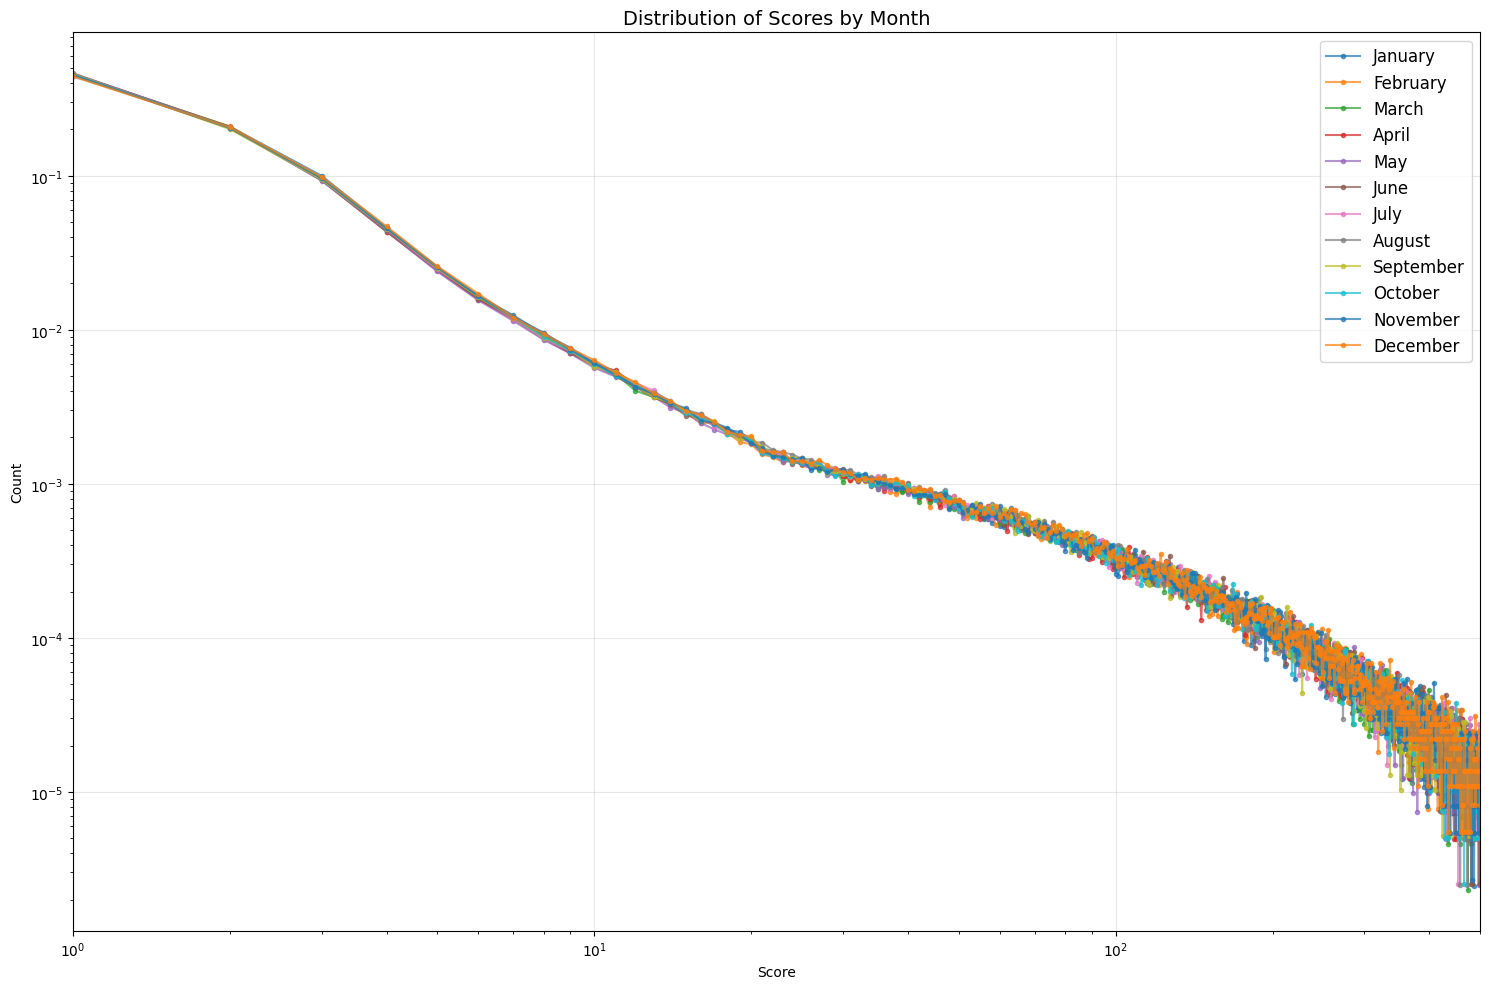

In [51]:
#plot histogram of scores by month
month_order = ['January  ', 'February ', 'March    ', 'April    ', 'May      ', 'June     ', 'July     ', 'August   ', 'September', 'October  ', 'November ', 'December ']
month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plot_loglog(by_month, 'month', month_order, month_labels, 'Distribution of Scores by Month')



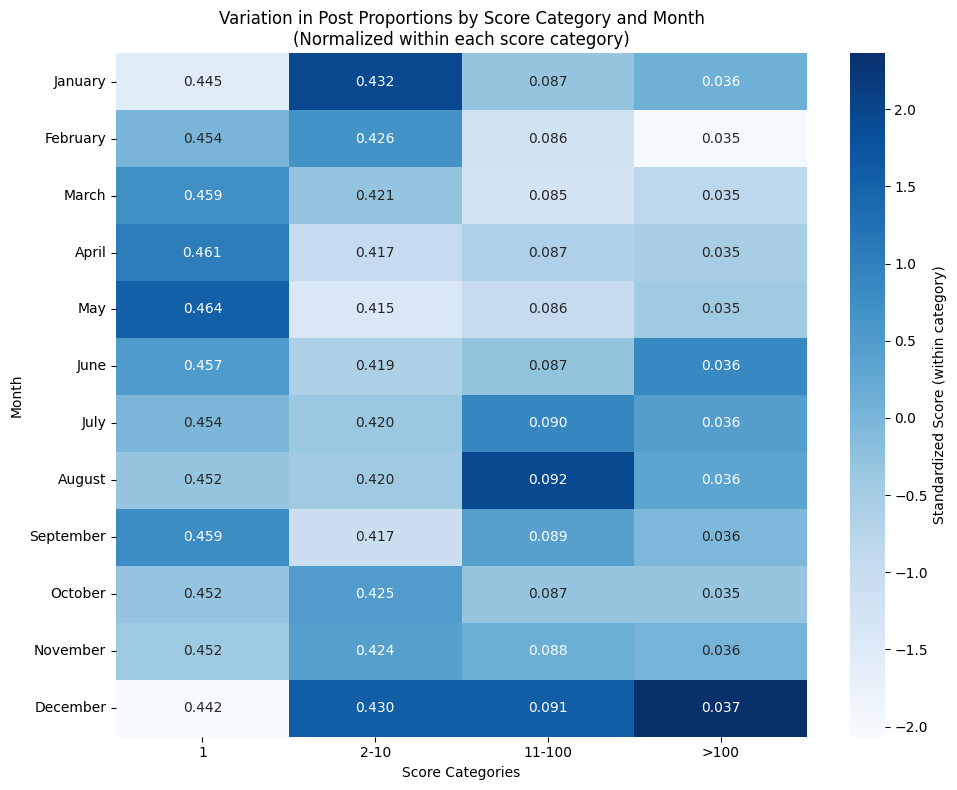

In [59]:
# Import seaborn for heatmap
import seaborn as sns

# First, we need to generate the data for months (similar to what show_score_categories does)
data_for_plot = {category: [] for category in categories}

# Process each month
for i, item in enumerate(month_order):
    item_data = by_month[by_month['month'] == item]

    # Group by score and sum the counts across hours in this time range
    aggregated = item_data.groupby('score')['count'].sum().reset_index()
    
    # Categorize scores and sum counts
    aggregated['category'] = aggregated['score'].apply(categorize_score)
    category_counts = aggregated.groupby('category')['count'].sum()
    
    # Calculate total posts for this time range
    total_posts = category_counts.sum()
    
    # Store proportions for each category (0 if category doesn't exist)
    for category in categories:
        count = category_counts.get(category, 0)
        proportion = count / total_posts if total_posts > 0 else 0
        data_for_plot[category].append(proportion)

# Create a pivot table and normalize each column separately
pivot_data = pd.DataFrame(data_for_plot, index=month_labels)

# Normalize each column to highlight variation within each score category
from sklearn.preprocessing import StandardScaler
pivot_normalized = pivot_data.copy()
for col in pivot_data.columns:
    col_data = pivot_data[col].values.reshape(-1, 1)
    scaler = StandardScaler()
    pivot_normalized[col] = scaler.fit_transform(col_data).flatten()

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_normalized, annot=pivot_data.values, fmt='.3f', cmap='Blues', 
            cbar_kws={'label': 'Standardized Score (within category)'})
plt.title('Variation in Post Proportions by Score Category and Month\n(Normalized within each score category)')
plt.ylabel('Month')
plt.xlabel('Score Categories')
plt.tight_layout()
plt.show()